#### Sepsis Prediction using Recurrent Neural Network
* Download the Prediction of Sepsis dataset from Kaggle: https://www.kaggle.com/datasets/salikhussaini49/prediction-of-sepsis and save it in storage/input
* Context - 
    * Sepsis is a major public health concern with significant morbidity, mortality, and healthcare expenses. Early detection and antibiotic treatment of sepsis improve outcomes. Hospital can also save cost for managing sepsis if sepsis can be predicted in advance.
* Challenge objective - 
    * To predict sepsis 6 hours before the clinical prediction of sepsis.

In [1]:
# Import necessary libraries
import pandas as pd
import os
from processor.library.preprocess.preprocess import preprocess
from processor.library.feature_engineering.Risk_score import Risk_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import math
import seaborn as sns
import matplotlib.pyplot as plt

Read dataset

In [2]:
# Get current directory
current_dir = os.getcwd()
# Join current directory with the path having dataset
file_path = os.path.join(current_dir,"storage/input/sepsis_dataset.csv")
# Read dataset 
df = pd.read_csv(file_path)
# Remove unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Print out raw data
print(df.head(5))

   Hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  BaseExcess  ...  \
0     0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN         NaN  ...   
1     1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN         NaN  ...   
2     2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN         NaN  ...   
3     3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN         NaN  ...   
4     4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN         NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54       0    NaN    NaN        -0.02       1   
1         NaN        NaN  68.54       0    NaN    NaN        -0.02       2   
2         NaN        NaN  68.54       0    NaN    NaN        -0.02       3   
3         NaN        NaN  68.54       0    NaN    NaN        -0.02       4   
4         NaN      330.0  68.54       0    NaN    NaN        -0.02       5   

   SepsisLabel  Patient_ID  
0            0       17072 

In [3]:
# Print out shape of raw data
print('Shape of df: ', df.shape)
# Print out the no: of unique patient id
print('No. of unique patient id: ', len(df["Patient_ID"].unique()))

Shape of df:  (1552210, 43)
No. of unique patient id:  40336


In [4]:
# drop Unit 1, Unit 2, and ICULOS columns
df2 = df.drop(['Unit1', 'Unit2', 'ICULOS'], axis=1)
print('Shape of df2: ', df2.shape)

Shape of df2:  (1552210, 40)


#### Train / test split according to patient ID

In [5]:
# Split train and test data by patient id
group_split = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=42)
split = group_split.split(df2.drop(['SepsisLabel','Patient_ID'], axis=1),groups=df2['Patient_ID'])
train_idx, test_idx = next(split)

In [6]:
# Training data - xtrain
x_train = df2.iloc[train_idx]
# Train label 
y_train = x_train[['SepsisLabel','Patient_ID']]
# drop sepsis label column from x_train
x_train = x_train.drop(['SepsisLabel'], axis=1)
print('size of xtrain: ', x_train.shape)
print('size of ytrain: ', y_train.shape)

# Evaluation data
x_eval = df2.iloc[test_idx]
y_eval = x_eval[['SepsisLabel','Patient_ID']]
# drop sepsis label column
x_eval = x_eval.drop(['SepsisLabel'], axis=1)
print('size of x_eval: ', x_eval.shape)
print('size of yeval: ', y_eval.shape)

size of xtrain:  (1241213, 39)
size of ytrain:  (1241213, 2)
size of x_eval:  (310997, 39)
size of yeval:  (310997, 2)


In [7]:
# column name list
column_names = list(x_train.columns.values)

#### Check for missing data in training dataset

In [8]:
# Check for missing data in xtrain
pre_process = preprocess()
result = pre_process.check_missingvalue(x_train)
print("Are there missing value in dataset: ", result['HasMissingValue'])
print("Missing values columns: ", result['missing_value_columns'])
print("Total number columns that has missing value: ", len(result['missing_value_columns']))

Are there missing value in dataset:  True
Missing values columns:  ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'HospAdmTime']
Total number columns that has missing value:  35


#### Missing data imputation by using Sklearn iterative imputation method

In [9]:
# Missing value imputation using iterative imputation from sklearn
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(x_train)

x_train = imp.transform(x_train)
x_eval = imp.transform(x_eval)

In [10]:
# numpy array to dataframe
x_train = pd.DataFrame(x_train, columns = column_names)
x_eval = pd.DataFrame(x_eval, columns = column_names)

#### Check for missing data again after imputation

In [11]:
# Check for missing data again after imputation
result = pre_process.check_missingvalue(x_train)
print("Are there missing value in x_train: ", result['HasMissingValue'])

result = pre_process.check_missingvalue(x_eval)
print("Are there missing value in x_eval: ", result['HasMissingValue'])

Are there missing value in x_train:  False
Are there missing value in x_eval:  False


#### Calculate Risk Scores - NEWs and SIRs scores

In [12]:
# Calculate Risk scores - NEWs and SIRs score
rs = Risk_score()
x_train = rs.Calculate_risk_score(x_train)
x_eval = rs.Calculate_risk_score(x_eval)

#### Check for balance / imbalance data

/home/peter/.local/share/virtualenvs/deep_learning_test-Kesrgl1c/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peter/.local/share/virtualenvs/deep_learning_test-Kesrgl1c/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peter/.local/share/virtualenvs/deep_learning_test-Kesrgl1c/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


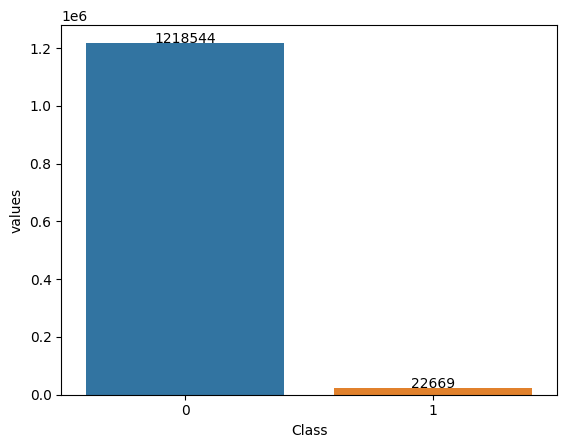

In [13]:
# Counts unique class value
class_ = y_train["SepsisLabel"].value_counts()
class_ = pd.DataFrame({'Class': class_.index,'values': class_.values})
# plot bar chart of different class count
ax = sns.barplot(x = 'Class', y = 'values', data = class_)
# Add values above bars
for i, v in enumerate(class_['values']):
   ax.text(i, v + 0.3, str(v), ha='center')
# Show the plot
plt.show()

#### Build Recurrent Neural Network, RNN using Pytorch

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Creating implementation of custom dataset and dataloader
class Patient_dataset(Dataset):
    # Initializing operations
    def __init__(self, input_f, labels):
        '''
            This function will perform initializing operation: reading input data (input_f), get unique patient ids and concatenate input data with label.
        '''
        self.data = input_f
        self.patients = self.data['Patient_ID'].unique()
        self.data = pd.concat([self.data.reset_index().drop(["index"],axis=1),labels.reset_index()["SepsisLabel"]],axis=1)
        

    def __len__(self):
        '''
            This function returns the size of the input data
        '''
        return len(self.patients) 

    def __getitem__(self, idx):
        '''
            This function will loads and returns a sample from the dataset at given index, idx. Based on the index, the function will 
                identify the location of the record, 
                convert that to a tensor,
                retrieve the corresponding label and
                return the tensor data, corresponding label and length of dataset in a tuple.
        '''
        intermediate = (self.data.loc[self.data["Patient_ID"] == self.patients[idx],:].drop(["Patient_ID","Hour","HospAdmTime"],axis=1))
        output = intermediate.drop(["SepsisLabel"],axis=1)
        labels = intermediate["SepsisLabel"]

        return torch.tensor(output.values), torch.tensor(labels.values), output.shape[0]

patient_df = Patient_dataset(x_train,y_train)

print('Length of patient data: ', patient_df.__len__())
print('Print the 4th element (3rd index) from output: ')
print('data: ', patient_df.__getitem__(3)[0].shape)
print(patient_df.__getitem__(3)[0])

print('label: ', patient_df.__getitem__(3)[1].shape)
print(patient_df.__getitem__(3)[1])

print('Total number of records: ', patient_df.__getitem__(3)[2])

Length of patient data:  32268
Print the 4th element (3rd index) from output: 
data:  torch.Size([36, 38])
tensor([[ 86.4284,  97.4984,  36.9425,  ...,   0.0000,   0.0000,   0.0000],
        [119.0000,  98.0000,  37.3910,  ...,   0.0000,   4.0000,   1.0000],
        [120.0000,  97.0000,  37.4114,  ...,   0.0000,   4.0000,   1.0000],
        ...,
        [109.0000, 100.0000,  37.3056,  ...,   0.0000,   3.0000,   1.0000],
        [121.0000,  98.0000,  37.4789,  ...,   0.0000,   4.0000,   1.0000],
        [124.0000,  98.0000,  36.8300,  ...,   0.0000,   5.0000,   1.0000]],
       dtype=torch.float64)
label:  torch.Size([36])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Total number of records:  36


#### Adjusting variable length of sequences with collate function
* Because different patients have different number of records (number of rows), there are non-uniform sequence in the dataset which means some patients have few records while the other patients have more records. 

* To handle sequences of non-uniform length, shorter sequences are needed to be padded to the length of the longest sequence in a batch.
This can be done using the collate_fn parameter of the DataLoader. 

In [15]:
def collate_fn(batch):

    # aggrate iterables in a tuple
    sequences, labels, lengths = zip(*batch)
    # convert length into 64-bit integer (signed)
    lengths = torch.LongTensor(lengths)
    # convert each sequence data into Tensor datatype
    sequences = [torch.Tensor(s) for s in sequences]
    # convert each label into Tensor datatype
    labels = [torch.Tensor(l) for l in labels]

    # pad_sequence function will stacks list of Tensors along a new dimension and pads them to equal length.
    # pad_sequence function will return a Tensor size (B x T x N). 
    #   B = batch size
    #   T = length of longest sequence (longest patient's records)
    #   N = length of features dimension
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels,batch_first=True,padding_value=-1)
    
    return sequences_padded, labels_padded, lengths

In [16]:
# Create an iterable dataset object (DataLoader) and iterate over it in batches, which are then fed into the model for processing
patient_dataloader = DataLoader(patient_df, batch_size=64, collate_fn=collate_fn, shuffle=True)

In [17]:
train_data, train_labels, size_in_each_batch = next(iter(patient_dataloader))
print('Train data: ', train_data.shape)
print(train_data)
print('\n')
print('Train label: ', train_labels.shape) # list type
print(train_labels)
print('\n')
print('Size in each batch: ', size_in_each_batch)

# print('shape of dataloader: ', i[0].shape, i[1].shape,i[2])

Train data:  torch.Size([64, 84, 38])
tensor([[[ 88.0853,  97.6027,  36.9762,  ...,   0.0000,   0.0000,   0.0000],
         [ 95.0000, 100.0000,  37.1100,  ...,   0.0000,   1.0000,   1.0000],
         [ 80.5000, 100.0000,  37.0380,  ...,   0.0000,   2.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ 84.8457,  97.3184,  37.0091,  ...,   1.0000,   0.0000,   0.0000],
         [ 73.5000, 100.0000,  36.0500,  ...,   1.0000,   0.0000,   0.0000],
         [ 74.0000, 100.0000,  36.4000,  ...,   1.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

      

#### Pack padded sequences
* It is difficult to batch the variable length sequences. Hence, it is necessary to pad all the sequences that will result in the longest sequence. In example, there are 4 sequences with variable length (for example, [89, 41, 45, 37]). If we want to pass these sequences to Recurrent Neural Network (RNN), we have to pad all the sequences to maximum sequence leng in each batch, which is 89.

* If we do the matrix multiplication this "padded batch of sequences" with weight matrix, there will be computation intensive and most of the computed results would be 0s because of zero padding to max length of sequence.

* Therefore, to optimize the processing of variable-length sequences, PyTorch uses packing sequences that allows us to process variable-length sequences without the need for padding. 

In [18]:
from torch.nn.utils.rnn import pack_padded_sequence

i = next(iter(patient_dataloader))
# Print one of pack padded sequences
pack_padded_sequence(i[1],torch.as_tensor(i[2]),batch_first=True,enforce_sorted=False)

PackedSequence(data=tensor([0, 0, 0,  ..., 1, 1, 1]), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 63, 60, 58, 56,
        53, 52, 51, 50, 50, 49, 46, 44, 41, 39, 38, 38, 38, 37, 37, 37, 36, 36,
        34, 29, 25, 24, 21, 20, 20, 18, 17, 16, 12, 12, 12, 12, 11, 10,  9,  8,
         6,  6,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1]), sorted_indices=tensor([13, 50, 20, 23, 29, 18, 25, 32, 11, 28,  9, 10, 27, 55, 52, 17, 34, 37,
        47, 56, 30, 51, 60, 35, 39, 26, 16, 59,  2, 40,  6, 36,  0, 49, 24, 62,
        19, 54,  4, 44, 12, 53,  1,  5, 43, 22, 61, 46,  7, 21, 63, 31, 14, 57,
        41, 45,  3, 42, 33, 38, 15,  8, 58, 48]), unsorted_indices=tensor([32, 42, 28, 56, 38, 43, 30, 48, 61, 10, 11,  8, 40,  0, 52, 60, 26, 15,
         5, 36,  2, 49

#### Train RNN

In [19]:
import torch.nn as nn

# Define Simple RNN
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, nonlinearity):
        super(SimpleRNN, self).__init__()

        # # Defining some parameters - Hidden layer size and number of layer
        # self.hidden_dim = hidden_size
        # self.n_layers = layer_size

        # Define multi-layer RNN 
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size, batch_first=True, nonlinearity=nonlinearity)
        # Applied layer normalization 
        self.norm = nn.LayerNorm(hidden_size)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        '''
            Forward pass.
        '''
        # Convert to floating point datatype.
        x = x.to(torch.float32)

        # pack the padded sequences to opimize computation
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # Pass both input and hidden state to into model and get outputs
        x, _ = self.rnn(x)
        # Pad the packed sequence before passing to fully connected network
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        # Normalize input
        x = self.norm(x)
        # Pass fully connected network
        x = self.fc(x)

        return x

In [20]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [21]:
# Number of features in the input data
input_size = int(train_data.shape[2])
# Number of features in the hidden state, h
hidden_size = int(input_size/2)
# number of recurrent layer
layer_size = 2
# Because it is binary classification problem, output have to be a vector of length 1
output_size = 1
# Nonlinearity function. Can be either 'tanh' or 'relu'
nonlinearity = 'relu'

# Instantiate the RNN model with hyperparameter
model = SimpleRNN(input_size=input_size, hidden_size=hidden_size, layer_size=layer_size, output_size=output_size, nonlinearity=nonlinearity)
# model.to(device)

#### Calculate the ratio between majority class (class 0) and minority class (class 1)
* This weight ratio will be used in weight loss to penalized majority class during training of RNN.

In [22]:
# implement weighted loss
# Total number of class 0
class0_count = (y_train['SepsisLabel']==0).sum()
print('class 0  count: ', class0_count)
# Total number of class 1
class1_count = (y_train['SepsisLabel']==1).sum()
print('class 1  count: ', class1_count)

# # Ratio
if class0_count > class1_count: 
    # weight_ratio = 1/class0_count/len(y_train)
    weight_ratio = class1_count/class0_count
else:
    # weight_ratio = 1/class1_count/len(y_train)
    weight_ratio = class0_count/class1_count

pos_weight = math.sqrt(weight_ratio**2)
print('Positibe weight value: ', pos_weight)

class 0  count:  1218544
class 1  count:  22669
Positibe weight value:  0.01860334957129164


In [23]:
# define loss function
loss_fn = nn.BCEWithLogitsLoss(reduction='none')
# loss_fn = nn.BCELoss()
# optimizer Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epoch = 5

# Training RNN loop
for epoch in range(num_epoch):  # Loop over the dataset multiple times
    for sequences, labels, lengths in patient_dataloader:
        # print('sequence shape: ', sequences.shape)
        # print('label shape: ', labels.shape)
        # print('lengths: ', lengths)
        
        # Zero the parameter gradients
        # During training every mini-batch, explicitly set all gradients to zero before start doing backpropagation (i.e., updating Weights and biases)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sequences, lengths)
        # print('output shape: ', outputs.shape)
        mask = (labels != -1).float()
        # print('mask shape: ', mask.shape)

        loss = loss_fn(outputs.squeeze(), labels.float())
        # Penalizing weight values of majority classes during back-propagation
        weights = torch.ones(labels.shape)
        weights[labels == 0] = pos_weight
        weights = torch.Tensor(np.array(weights))
        loss = loss * weights
        # print('loss shape: ', loss.shape)
        loss = (loss * mask).sum(axis=1) / mask.sum(axis=1)
        # print('after mask, loss shape: ', loss.shape)
        loss = loss.mean()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        print(f'Loss: {loss.item()}')

print('Finished Training')

Loss: 0.03236616775393486
Loss: 0.03232957050204277
Loss: 0.02325868047773838
Loss: 0.03799263387918472
Loss: 0.030926857143640518
Loss: 0.032350171357393265
Loss: 0.027422336861491203
Loss: 0.02473219856619835
Loss: 0.040272850543260574
Loss: 0.02650294452905655
Loss: 0.02018027752637863
Loss: 0.03535814955830574
Loss: 0.018626578152179718
Loss: 0.022990580648183823
Loss: 0.027325084432959557
Loss: 0.019270632416009903
Loss: 0.03280510753393173
Loss: 0.025455109775066376
Loss: 0.01883293315768242
Loss: 0.014445607550442219
Loss: 0.025002628564834595
Loss: 0.043582845479249954
Loss: 0.01701677031815052
Loss: 0.05745823308825493
Loss: 0.024702202528715134
Loss: 0.024015657603740692
Loss: 0.03250914812088013
Loss: 0.02458496391773224
Loss: 0.014651858247816563
Loss: 0.021253284066915512
Loss: 0.02209407463669777
Loss: 0.032522596418857574
Loss: 0.02692720852792263
Loss: 0.029656069353222847
Loss: 0.01629670150578022
Loss: 0.03253084421157837
Loss: 0.026459727436304092
Loss: 0.02685339376

In [24]:
# Training dataset
train_result = defaultdict(list)

with torch.no_grad():
    for train_seq, train_labels, train_lengths in patient_dataloader:

        model_predict = model(train_seq, train_lengths)
        m = nn.Sigmoid()
        predict_prob = m(model_predict)

        # mask = (labels != -1).float()
        # ypredict = ypredict*mask

        predict_label = (predict_prob >= 0.5).int()

        mask = (train_labels != -1)
        train_label = train_labels[mask]

        predict_label = predict_label[:,:,0]
        predict_label = predict_label[mask]

        predict_prob = predict_prob[:,:,0]
        predict_prob = predict_prob[mask]
        predict_prob = predict_prob.flatten()

        train_result['prediction_label'].extend(predict_label.squeeze().tolist())
        train_result['true_label'].extend(train_label.tolist())
        train_result['predict_prob'].extend(predict_prob.tolist())

In [25]:
y_train = train_result['true_label']
ytrain_pred = train_result['prediction_label']
train_prob = train_result['predict_prob']

# Print classification report
print(classification_report(y_train, ytrain_pred))
# ROC curve
fpr_train,tpr_train,threshold=roc_curve(y_train,train_prob)
auroc_train=roc_auc_score(y_train,train_prob)
print('Train: auroc ',auroc_train)

              precision    recall  f1-score   support

           0       0.99      0.57      0.72   1218544
           1       0.03      0.70      0.06     22669

    accuracy                           0.57   1241213
   macro avg       0.51      0.63      0.39   1241213
weighted avg       0.97      0.57      0.71   1241213

Train: auroc  0.692751296767565


#### Prediction of evaluation data

In [26]:
# Evaluation dataloader
eval_df = Patient_dataset(x_eval,y_eval)
eval_dataloader = DataLoader(eval_df, batch_size=64, collate_fn=collate_fn, shuffle=True)

In [27]:
eval_result = defaultdict(list)

with torch.no_grad():
    for eval_seq, eval_labels, eval_lengths in eval_dataloader:

        model_predict = model(eval_seq, eval_lengths)
        # print(model_predict)
        # print(' ')
        m = nn.Sigmoid()
        predict_prob = m(model_predict)

        # mask = (labels != -1).float()
        # ypredict = ypredict*mask

        predict_label = (predict_prob >= 0.5).int()

        mask = (eval_labels != -1)
        eval_label = eval_labels[mask]

        predict_label = predict_label[:,:,0]
        predict_label = predict_label[mask]

        predict_prob = predict_prob[:,:,0]
        predict_prob = predict_prob[mask]
        predict_prob = predict_prob.flatten()

        eval_result['prediction_label'].extend(predict_label.squeeze().tolist())
        eval_result['true_label'].extend(eval_label.tolist())
        eval_result['predict_prob'].extend(predict_prob.tolist())

In [28]:
y_eval = eval_result['true_label']
yeval_pred = eval_result['prediction_label']
eval_prob = eval_result['predict_prob']

# Print classification report
print(classification_report(y_eval, yeval_pred))
# ROC curve
fpr_eval,tpr_eval,threshold=roc_curve(y_eval,eval_prob)
auroc=roc_auc_score(y_eval,eval_prob)
print('Test: auroc ',auroc)

              precision    recall  f1-score   support

           0       0.99      0.58      0.73    305750
           1       0.03      0.70      0.05      5247

    accuracy                           0.58    310997
   macro avg       0.51      0.64      0.39    310997
weighted avg       0.97      0.58      0.72    310997

Test: auroc  0.6985315631826994


#### Plot ROC curve

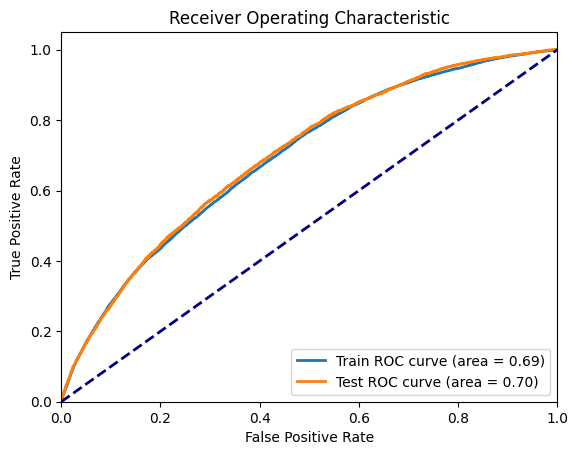

In [29]:
plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label="Train ROC curve (area = %0.2f)" % auroc_train)
plt.plot(fpr_eval, tpr_eval, lw=2, label = "Test ROC curve (area = %0.2f)" % auroc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

Reference:
1. Why do we pack the sequences in PyTorch | Saturn Cloud Blog. (2023, September 7). https://saturncloud.io/blog/why-do-we-pack-the-sequences-in-pytorch/
2. Why do we “pack” the sequences in PyTorch? (n.d.). Stack Overflow. https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
3. W&B. (2023). Weights & biases. W&B. https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1
4. Reyna, M. A., Josef, C. S., Jeter, R., Shashikumar, S. P., Westover, M. B., Nemati, S., Clifford, G. D., & Sharma, A. (2020). Early prediction of sepsis from clinical data: The PhysioNet/Computing in Cardiology Challenge 2019. Critical Care Medicine, 48(2), 210–217. https://doi.org/10.1097/ccm.0000000000004145